In [1]:
from __future__ import print_function
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils import model_to_dot


Using TensorFlow backend.


In [2]:
BASE_DIR = ''
GLOVE_DIR = os.path.join(BASE_DIR, '/media/root/par2/glove.6B')
TEXT_DATA_DIR = os.path.join(BASE_DIR, '/media/root/par2/20_newsgroup')
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.25
print('Indexing word vectors.')

Indexing word vectors.


In [3]:
embeddings_index = {}
with open(os.path.join(GLOVE_DIR, '/media/root/par2/glove.6B/glove.6B.100d.txt')) as f:
 for line in f:
     
        word, coefs = line.split(" ", 1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [4]:
print('Processing text dataset')

texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
                with open(fpath, **args) as f:
                    t = f.read()
                    i = t.find('\n\n')  # skip header
                    if 0 < i:
                        t = t[i:]
                    texts.append(t)
                labels.append(label_id)

print('Found %s texts.' % len(texts))

Processing text dataset
Found 19997 texts.


In [5]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 174105 unique tokens.
Shape of data tensor: (19997, 1000)
Shape of label tensor: (19997, 20)


In [6]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

print('Preparing embedding matrix.')

Preparing embedding matrix.


In [7]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

print('Training model.')

Training model.


In [8]:
# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
model.fit(x_train, y_train,
          batch_size=256,
          epochs=10,
          validation_data=(x_val, y_val))




Train on 14998 samples, validate on 4999 samples
Epoch 1/10
14998/14998 [==============================] - 117s 8ms/step - loss: 2.6974 - acc: 0.1429 - val_loss: 2.5169 - val_acc: 0.1862
Epoch 2/10
14998/14998 [==============================] - 106s 7ms/step - loss: 1.8912 - acc: 0.3558 - val_loss: 1.5384 - val_acc: 0.4623
Epoch 3/10
14998/14998 [==============================] - 109s 7ms/step - loss: 1.4450 - acc: 0.5037 - val_loss: 1.3475 - val_acc: 0.5343
Epoch 4/10
14998/14998 [==============================] - 107s 7ms/step - loss: 1.1356 - acc: 0.6150 - val_loss: 1.0707 - val_acc: 0.6293
Epoch 5/10
14998/14998 [==============================] - 106s 7ms/step - loss: 0.9313 - acc: 0.6850 - val_loss: 0.9662 - val_acc: 0.6747
Epoch 6/10
14998/14998 [==============================] - 107s 7ms/step - loss: 0.7666 - acc: 0.7424 - val_loss: 0.8398 - val_acc: 0.7143
Epoch 7/10
14998/14998 [==============================] - 106s 7ms/step - loss: 0.6423 - acc: 0.7878 - val_loss: 0.8508 -

In [9]:
print(model.summary())

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
print ("arch saved at /media/root/par2/scripts/")


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         2000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 35, 128)           8204

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [10]:
# build history for Training  accuracy 
#train on the training se
import matplotlib.pyplot as plt
history = model.fit(x_train, y_train, validation_split=0.25, epochs=10, batch_size=256, verbose=1)

Train on 11248 samples, validate on 3750 samples
Epoch 1/10
11248/11248 [==============================] - 85s 8ms/step - loss: 0.3296 - acc: 0.8941 - val_loss: 0.4125 - val_acc: 0.8555
Epoch 2/10
11248/11248 [==============================] - 84s 7ms/step - loss: 0.2792 - acc: 0.9085 - val_loss: 0.2854 - val_acc: 0.9053
Epoch 3/10
11248/11248 [==============================] - 90s 8ms/step - loss: 0.2254 - acc: 0.9296 - val_loss: 0.2939 - val_acc: 0.8989
Epoch 4/10
11248/11248 [==============================] - 90s 8ms/step - loss: 0.2084 - acc: 0.9316 - val_loss: 0.3747 - val_acc: 0.8835
Epoch 5/10
11248/11248 [==============================] - 87s 8ms/step - loss: 0.1733 - acc: 0.9457 - val_loss: 0.5066 - val_acc: 0.8491
Epoch 6/10
11248/11248 [==============================] - 91s 8ms/step - loss: 0.1738 - acc: 0.9512 - val_loss: 0.3360 - val_acc: 0.8917
Epoch 7/10
11248/11248 [==============================] - 91s 8ms/step - loss: 0.1545 - acc: 0.9519 - val_loss: 0.3485 - val_acc:

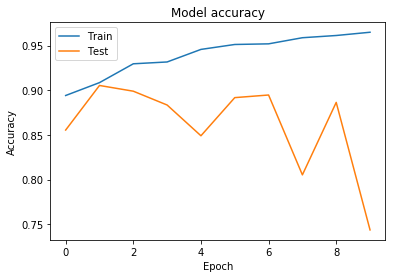

In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

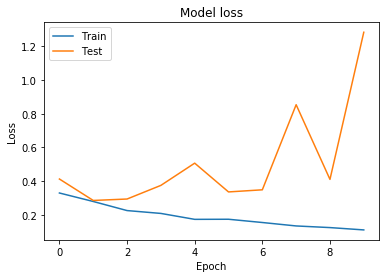

In [12]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_val, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.8036
Testing Accuracy:  0.6675
